In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/My Drive/P3')

# Watch out for unexpected movie recommendations !

# Introduction

Our primary goal is to enhance content-based recommendations by uncovering hidden topics within movie plots using Latent Dirichlet Allocation (LDA). By identifying these latent themes, we can move beyond conventional genre-based recommendations to suggest movies with deeper, thematic similarities.

<div style="border-left: 6px solid rgba(69, 157, 185, 1);border-radius:5px; box-shadow: 3px 3px 3px rgba(221, 221, 221, 1);" >
    <p style="background-color: rgba(69, 157, 185, 0.1); font-weight:bold; padding: 8px 0 8px 15px;">Analysis</p>
    <div style="padding: 0 0 2px 10px;">
    
**What will be covered :**
- **Part 1 :** Data Exploration and Processing
- **Part 2 :** Topics Detection
- **Part 3 :** Are topics linked to genres?
- **Part 4 (Bonus) :** Recommendation algorithm
- **Part 5 :** Recommendation Analysis
- **Part 6 :** Additional features Analysis

</div></div>
<br/>

---

# Part 1.1 : Data Exploration and Processing

### Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import Image
#import streamlit as st
#from wordcloud import WordCloud
from collections import Counter

# Setting notebook to work offline
pyo.init_notebook_mode()
import ast
import os
import sys
sys.path.append(os.path.abspath("src/utils"))
!pip install IMDbPY
from helpers import *

# LDA
import spacy
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
# gensim is a popular library for topic modelling
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pickle

from imdb import IMDb
import re
import kagglehub # To extract synopsis dataframes

/bin/bash: pip: command not found


## 1.1 Dataset exploration

### Load initial movie dataset

In [4]:
movie_columnns =['Wikipedia movie ID','Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres']
movie = pd.read_csv('Data/movie.metadata.tsv', sep='\t', header=None, names=movie_columnns)

print('The dataset contains', movie.shape[0], 'movies and',movie.shape[1] , 'features.')
movie.head()

The dataset contains 81741 movies and 9 features.


Wikipedia movie ID Freebase movie ID  \
0              975900         /m/03vyhn   
1             3196793         /m/08yl5d   
2            28463795        /m/0crgdbh   
3             9363483        /m/0285_cd   
4              261236         /m/01mrr1   

                                          Movie name Movie release date  \
0                                     Ghosts of Mars         2001-08-24   
1  Getting Away with Murder: The JonBenét Ramsey ...         2000-02-16   
2                                        Brun bitter               1988   
3                                   White Of The Eye               1987   
4                                  A Woman in Flames               1983   

   Movie box office revenue  Movie runtime  \
0                14010832.0           98.0   
1                       NaN           95.0   
2                       NaN           83.0   
3                       NaN          110.0   
4                       NaN          106.0   

                      Movie languages  \
0  {"/m/02h40lc": "English Language"}   
1  {"/m/02h40lc": "English Language"}   
2  {"/m/05f_3": "Norwegian Language"}   
3  {"/m/02h40lc": "English Language"}   
4   {"/m/04306rv": "German Language"}   

                             Movie countries  \
0  {"/m/09c7w0": "United States of America"}   
1  {"/m/09c7w0": "United States of America"}   
2                     {"/m/05b4w": "Norway"}   
3             {"/m/07ssc": "United Kingdom"}   
4                    {"/m/0345h": "Germany"}   

                                        Movie genres  
0  {"/m/01jfsb": "Thriller", "/m/06n90": "Science...  
1  {"/m/02n4kr": "Mystery", "/m/03bxz7": "Biograp...  
2  {"/m/0lsxr": "Crime Fiction", "/m/07s9rl0": "D...  
3  {"/m/01jfsb": "Thriller", "/m/0glj9q": "Erotic...  
4                            {"/m/07s9rl0": "Drama"}

## Features Descriptions

| Column                | Description                                                                        |
|-----------------------|------------------------------------------------------------------------------------|
| Wikipedia movie ID    | An identifier for each movie from Wikipedia.                                       |
| Freebase movie ID     | A unique identifier for each movie from the Freebase database.                     |
| Movie name            | The title of the movie.                                                            |
| Movie release date    | The date when the movie was released, formatted as `YYYY-MM-DD`.                   |
| Movie box office revenue | The revenue generated by the movie at the box office (in dollars). |
| Movie runtime         | The duration of the movie in minutes. |
| Movie languages       | A dictionary where keys represent Freebase language IDs, and values represent the language names (e.g., English, Norwegian, German). |
| Movie countries       | A dictionary where keys are Freebase country IDs, and values are country names representing where the movie was produced. |
| Movie genres          | A dictionary where each key represents a Freebase genre ID, and each value represents the corresponding genre of the movie. |

### Comment
Not all features will be useful to our analysis:
- `Movie runtime` is not used in the analysis

#### Drop columns

In [5]:
# Creat new df with updated columns
movie_drop = movie.drop(['Freebase movie ID'], axis=1)

# Visual check
movie_drop.columns

Index(['Wikipedia movie ID', 'Movie name', 'Movie release date',
       'Movie box office revenue', 'Movie runtime', 'Movie languages',
       'Movie countries', 'Movie genres'],
      dtype='object')

Columns has been efficiently dropped.

## Features types

In [6]:
pd.DataFrame(movie_drop.dtypes, columns=['Type'])

Type
Wikipedia movie ID          int64
Movie name                 object
Movie release date         object
Movie box office revenue  float64
Movie runtime             float64
Movie languages            object
Movie countries            object
Movie genres               object

### Comment
1. The `Movie languages`, `Movie countries` and `Movie genres` are stored in dictionnaries with `Freebase movie ID` as keys. Since the `Freebase movie ID` are not kept the dictionnaries will be changed to keep values only.

2. For our analysis, having the full release date in `Movie release date` isn't necessary, just the year is enough. Therefore, we convert the release date into a year format (e.g. 1995-07-21 becomes 1995).

In [7]:
movies_df = movie_drop.copy()
movies_df['Movie genres'] = convert_to_list(movies_df, 'Movie genres')
movies_df['Movie languages'] = convert_to_list(movies_df, 'Movie languages')
movies_df['Movie countries'] = convert_to_list(movies_df, 'Movie countries')

movies_df[['Movie genres','Movie languages', 'Movie countries']].head()

Movie genres       Movie languages  \
0  [Thriller, Science Fiction, Horror, Adventure,...    [English Language]   
1   [Mystery, Biographical film, Drama, Crime Drama]    [English Language]   
2                             [Crime Fiction, Drama]  [Norwegian Language]   
3  [Thriller, Erotic thriller, Psychological thri...    [English Language]   
4                                            [Drama]     [German Language]   

              Movie countries  
0  [United States of America]  
1  [United States of America]  
2                    [Norway]  
3            [United Kingdom]  
4                   [Germany]

We can now see that the columns containing information about movie languages, countries, and genres are indeed formatted as lists.

In [37]:
# Convert string to year
movies_df['Movie release date'] = movies_df['Movie release date'].apply(extract_year).astype('Int64')

# Check that all movies release dates are encoded in years
print(movies_df['Movie release date'].head())

0    1970
1    1970
2    1970
3    1970
4    1970
Name: Movie release date, dtype: Int64


The release dates are now in years format!

# 1.2 Getting Synopses
To discover the underlying topics of the movies with LDA we will need the synopses. We decide not to use the movies summaries since they encode significantly less context and would result in less confident clustering.

### Synopses
For synopses the MPST dataset is used, this dataset is usually used for supervised learning of tags prediction using plot synopsis.

Features:

| Column                | Description                                                                        |
|-----------------------|------------------------------------------------------------------------------------|
| imdb_id	    | An identifier for each movie from IMdB.                                       |
| plot_synopsis	     | Whole movie plot description.                     |
| title            | The title of the movie.                                                            |
| tags	    | Topics present in the movie..                   |
| split | Describe if used for training, validation or testing. |
| synopsis_source         | Plateform from which the synopsis. |


In [11]:
# Load data
synopsis = pd.read_csv('Data/mpst_full_data.csv')

# Check data shape
print("This synopsis dataframe is of size:", synopsis.shape)

# Display df
synopsis.head()

This synopsis dataframe is of size: (14828, 6)


imdb_id                                          title  \
0  tt0057603                        I tre volti della paura   
1  tt1733125  Dungeons & Dragons: The Book of Vile Darkness   
2  tt0033045                     The Shop Around the Corner   
3  tt0113862                             Mr. Holland's Opus   
4  tt0086250                                       Scarface   

                                       plot_synopsis  \
0  Note: this synopsis is for the orginal Italian...   
1  Two thousand years ago, Nhagruul the Foul, a s...   
2  Matuschek's, a gift store in Budapest, is the ...   
3  Glenn Holland, not a morning person by anyone'...   
4  In May 1980, a Cuban man named Tony Montana (A...   

                                                tags  split synopsis_source  
0          cult, horror, gothic, murder, atmospheric  train            imdb  
1                                           violence  train            imdb  
2                                           romantic   test            imdb  
3             inspiring, romantic, stupid, feel-good  train            imdb  
4  cruelty, murder, dramatic, cult, violence, atm...    val            imdb

### MPST Features
| Column                | Description                                                                        |
|-----------------------|------------------------------------------------------------------------------------|
| imdb_id	    | An identifier for each movie from IMdB.                                       |
| plot_synopsis	     | Whole movie plot description.                     |
| title            | The title of the movie.                                                            |
| tags	    | Topics present in the movie..                   |
| split | Describe if used for training, validation or testing. |
| synopsis_source         | Plateform from which the synopsis. |


### Comment
Not all features will be useful to our analysis:
- The `split` feature is not relevant since we perform an unsupervised analysis
- `synopsis_source` is not used in the analysis

So both of those features will be dropped.

## Combinig both datasets

In [38]:
# Merge by matching titles
movies_syn = synopsis.merge(movies_df, left_on='title', right_on='Movie name', how='inner')

# Remove columns
movies_syn.drop(columns=['title', 'split', 'synopsis_source'], inplace=True)

# Display
movies_syn.head(3)

imdb_id                                      plot_synopsis  \
0  tt1733125  Two thousand years ago, Nhagruul the Foul, a s...   
1  tt0033045  Matuschek's, a gift store in Budapest, is the ...   
2  tt0113862  Glenn Holland, not a morning person by anyone'...   

                                     tags  Wikipedia movie ID  \
0                                violence            30855958   
1                                romantic               76353   
2  inspiring, romantic, stupid, feel-good              171076   

                                      Movie name  Movie release date  \
0  Dungeons & Dragons: The Book of Vile Darkness                1970   
1                     The Shop Around the Corner                1970   
2                             Mr. Holland's Opus                1970   

   Movie box office revenue  Movie runtime  \
0                       NaN           90.0   
1                       NaN           98.0   
2               106269971.0          130.0   

                              Movie languages             Movie countries  \
0                                          []            [United Kingdom]   
1                          [English Language]  [United States of America]   
2  [English Language, American Sign Language]  [United States of America]   

                                        Movie genres  
0                                          [Fantasy]  
1  [Romantic comedy, Workplace Comedy, Black-and-...  
2  [Inspirational Drama, Family Film, Drama, Musi...

### How many movies have no matching synopsis?

In [14]:
# Compare size before and after merge
lost_rows = synopsis.shape[0] - movies_syn.shape[0]
print(f"We only lost {lost_rows} movies by merging the two dataset by the titles of the movies.")

We only lost 94 movies by merging the two dataset by the titles of the movies.


### Comment

1. Movie loss: The size fo the dataframe has not significantly changed, only 94 movies did not match. Our original movie df contained most of the movies present in the synopsis df.

2. Same title: We also observe that Scarface appears twice since there was a remake. For the rest for the analysis we will assume that if the name of the movie is exactly the same, the synopsis is pretty similar for both movies (if not the same!).

# 1.3 Getting Ratings
Rating reflect important information when talking about recommendation. They directly reflect how much someone enjoyed a movie.
Thus we found an IMdB dataset online which contains movie ratings.

In [15]:
# Load dataset
ratings_df = pd.read_csv('Data/title.ratings.tsv', sep='\t')
ratings_df.head()

tconst  averageRating  numVotes
0  tt0000001            5.7      2100
1  tt0000002            5.6       282
2  tt0000003            6.5      2119
3  tt0000004            5.4       182
4  tt0000005            6.2      2850

### Columns
| Feature         | Description                                      |
|-----------------|--------------------------------------------------|
| tconst          | IMDb ID (unique identifier for a movie)           |
| average rating  | Mean of all ratings given to the movie           |
| numVotes        | Number of people who rated the movie             |

Since both of our datasets contain information about the `imdb_id`, we can merge them using this information.

## Merging both datasets

In [16]:
# Merge
movies_ratings = pd.merge(movies_syn,ratings_df,left_on='imdb_id', right_on='tconst',how='inner')

# Remove redundant columns
movies_ratings = movies_ratings.drop(['tconst'], axis=1)

# Display
movies_ratings.head(3)

imdb_id                                      plot_synopsis  \
0  tt1733125  Two thousand years ago, Nhagruul the Foul, a s...   
1  tt0033045  Matuschek's, a gift store in Budapest, is the ...   
2  tt0113862  Glenn Holland, not a morning person by anyone'...   

                                     tags  Wikipedia movie ID  \
0                                violence            30855958   
1                                romantic               76353   
2  inspiring, romantic, stupid, feel-good              171076   

                                      Movie name  Movie release date  \
0  Dungeons & Dragons: The Book of Vile Darkness                2012   
1                     The Shop Around the Corner                1940   
2                             Mr. Holland's Opus                1995   

   Movie box office revenue  Movie runtime  \
0                       NaN           90.0   
1                       NaN           98.0   
2               106269971.0          130.0   

                              Movie languages             Movie countries  \
0                                          []            [United Kingdom]   
1                          [English Language]  [United States of America]   
2  [English Language, American Sign Language]  [United States of America]   

                                        Movie genres  averageRating  numVotes  
0                                          [Fantasy]            4.4      2722  
1  [Romantic comedy, Workplace Comedy, Black-and-...            8.0     39430  
2  [Inspirational Drama, Family Film, Drama, Musi...            7.3     42246

## Comment: Complete Dataset
Our dataset is complete! We can start to analyse the data.

In [17]:
# save .csv file to import it in box_office_extraction.py
movies_ratings.to_csv('Data/movies_ratings.csv', index=False)

# Part 2: Data Analysis

## Part 2.1 Handling Missing Values

Our dataset is now complete for the analysis, however we need to check the NaN values before.

In [19]:
# Replace empty lists with NaN
movies_ratings = movies_ratings.applymap(replace_empty_with_nan)
movies_ratings.head(2)

<ipython-input-19-b0a7cf8d0b59>:2: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



imdb_id                                      plot_synopsis      tags  \
0  tt1733125  Two thousand years ago, Nhagruul the Foul, a s...  violence   
1  tt0033045  Matuschek's, a gift store in Budapest, is the ...  romantic   

   Wikipedia movie ID                                     Movie name  \
0            30855958  Dungeons & Dragons: The Book of Vile Darkness   
1               76353                     The Shop Around the Corner   

   Movie release date  Movie box office revenue  Movie runtime  \
0              2012.0                       NaN           90.0   
1              1940.0                       NaN           98.0   

      Movie languages             Movie countries  \
0                 NaN            [United Kingdom]   
1  [English Language]  [United States of America]   

                                        Movie genres  averageRating  numVotes  
0                                          [Fantasy]            4.4      2722  
1  [Romantic comedy, Workplace Comedy, Black-and-...            8.0     39430

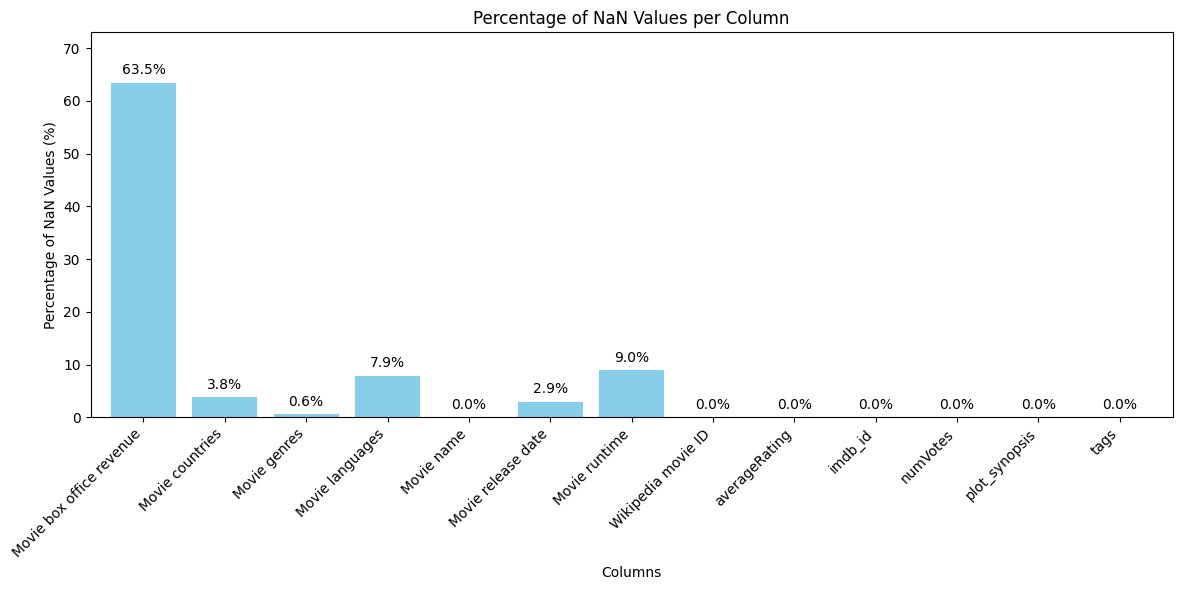

In [20]:
# Calculate percentage of NaN values in each column
na_percentage = (movies_ratings.isna().sum() / len(movies_ratings)) * 100
na_percentage = na_percentage.sort_index()

# Plot
plt.figure(figsize=(12, 6))
bars = na_percentage.plot(kind='bar', color='skyblue', width=0.8)

# Add percentage labels on top of each bar
for i, value in enumerate(na_percentage):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

plt.xlabel('Columns')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of NaN Values (%)')
plt.ylim(top =73)
plt.title('Percentage of NaN Values per Column')
plt.tight_layout()

plt.show()


Five columns contain Missing values:
- `Movie box office revenue` which has 63.5% of missing values, is very problematic, since this feature is used to answer some research questions. We will try to find external information to fill the gaps.
- `Movie languages` with 7.9% of NaNs
- `Movie countries` with 3.8% of NaNs
- `Movie release date` with 2.9% of NaNs
- `Movie genres` with 0.6% of NanS
- `Movie runtime` with 9.0% of NanS

### Handling Nans for Movie box office revenue

Since not all the features are used in all analysis we will first handle the `Movies genres` missing values for the LDA analysis. And in a second time handle all features missing values for the features analysis.


#### Handling NaNs Features Analysis

**Box office**

Since the number of NaNs in the box-office revenue column is significant we try to enrich the dataset with data from IMbD. The code to extract the box office with the IMdB library can be found in the `src/scripts/box_office_extraction.py` file. The run time is very long, therefore we run it one time and save the results in a .csv file that we import here.

In [21]:
#Here is the file with completed box-office from Imdb (last column)
new_movies_dataset = pd.read_csv('Data/movies_synopsis_comp.csv')

# Add IMDB box office to original dataset
movies_ratings['IMDB Box-office'] = new_movies_dataset['IMDB Box-office']

#Improvement in NaN values in box-office
na_percentage_box_init = (movies_ratings['Movie box office revenue'].isna().sum() / len(movies_ratings)) * 100
na_percentage_box_imdb = (movies_ratings['IMDB Box-office'].isna().sum() / len(movies_ratings)) * 100
print(f"We went from {round(na_percentage_box_init,2)}% of NaN values to {round(na_percentage_box_imdb,2)}%.")
movies_ratings.drop('Movie box office revenue', axis=1, inplace=True) # Remove old column


We went from 63.47% of NaN values to 54.8%.


### Comment
The increase is a bit deceiving. The IMDB library is missing a lot of box-offices too. We suspect the IMDB library to maybe block requests when there are too many, giving more NaN values than there actually are. In the end that's still an increase of 11% in box-office data size. Since we expect the box office to play an important role in movies' similarities we chose to remove all movies with no box office information

In [22]:
features_df = movies_ratings.dropna()

# Display
print("Out of", movies_ratings.shape[0],"movies",  movies_ratings.shape[0] - features_df.shape[0], "have missing information and were removed from the dataset")
features_df.head()

Out of 14686 movies 8782 have missing information and were removed from the dataset


imdb_id                                      plot_synopsis  \
1  tt0033045  Matuschek's, a gift store in Budapest, is the ...   
2  tt0113862  Glenn Holland, not a morning person by anyone'...   
3  tt0086250  In May 1980, a Cuban man named Tony Montana (A...   
4  tt0086250  In May 1980, a Cuban man named Tony Montana (A...   
5  tt1315981  George Falconer (Colin Firth) approaches a car...   

                                                tags  Wikipedia movie ID  \
1                                           romantic               76353   
2             inspiring, romantic, stupid, feel-good              171076   
3  cruelty, murder, dramatic, cult, violence, atm...               76331   
4  cruelty, murder, dramatic, cult, violence, atm...              267848   
5                         romantic, queer, flashback            24207129   

                   Movie name  Movie release date  Movie runtime  \
1  The Shop Around the Corner              1940.0           98.0   
2          Mr. Holland's Opus              1995.0          130.0   
3                    Scarface              1932.0           94.0   
4                    Scarface              1983.0          170.0   
5                A Single Man              2009.0          101.0   

                              Movie languages             Movie countries  \
1                          [English Language]  [United States of America]   
2  [English Language, American Sign Language]  [United States of America]   
3        [Italian Language, English Language]  [United States of America]   
4        [English Language, Spanish Language]  [United States of America]   
5        [English Language, Spanish Language]  [United States of America]   

                                        Movie genres  averageRating  numVotes  \
1  [Romantic comedy, Workplace Comedy, Black-and-...            8.0     39430   
2  [Inspirational Drama, Family Film, Drama, Musi...            7.3     42246   
3  [Crime Fiction, Gangster Film, Black-and-white...            8.3    939727   
4  [Crime Fiction, Thriller, Gangster Film, Actio...            8.3    939727   
5  [LGBT, Romantic drama, Romance Film, Drama, Fi...            7.5    119168   

   IMDB Box-office  
1         380000.0  
2      106269971.0  
3       65884703.0  
4       65884703.0  
5       24964890.0

### Handling Nans LDA analysis
We remove movies with no information on `Movie genres` since we are interested in the genre for our topic analysis.

In [23]:
# Drop all movies with no Movie release dates
LDA_df = movies_ratings[['imdb_id', 'plot_synopsis', 'tags', 'Movie genres']].dropna(subset=['Movie genres'])

# Display
print("Out of", movies_ratings.shape[0],"movies",  movies_ratings.shape[0]-LDA_df.shape[0], "have missing genre information and were removed from the dataset")
LDA_df.head()

Out of 14686 movies 82 have missing genre information and were removed from the dataset


imdb_id                                      plot_synopsis  \
0  tt1733125  Two thousand years ago, Nhagruul the Foul, a s...   
1  tt0033045  Matuschek's, a gift store in Budapest, is the ...   
2  tt0113862  Glenn Holland, not a morning person by anyone'...   
3  tt0086250  In May 1980, a Cuban man named Tony Montana (A...   
4  tt0086250  In May 1980, a Cuban man named Tony Montana (A...   

                                                tags  \
0                                           violence   
1                                           romantic   
2             inspiring, romantic, stupid, feel-good   
3  cruelty, murder, dramatic, cult, violence, atm...   
4  cruelty, murder, dramatic, cult, violence, atm...   

                                        Movie genres  
0                                          [Fantasy]  
1  [Romantic comedy, Workplace Comedy, Black-and-...  
2  [Inspirational Drama, Family Film, Drama, Musi...  
3  [Crime Fiction, Gangster Film, Black-and-white...  
4  [Crime Fiction, Thriller, Gangster Film, Actio...

## Part 2.2 Data exploration

We have both clean dataframes Let's look at their distributions

### Movies' summaries exploration

In [48]:
# Lengths of each plot synopsis
summary_lengths = LDA_df['plot_synopsis'].apply(len)

# Stats of plot synopsis length
LDA_df['plot_synopsis'].apply(lambda x: len(x)).describe().round()

count    14604.0
mean      5427.0
std       5028.0
min        656.0
25%       2616.0
50%       4000.0
75%       6169.0
max      63959.0
Name: plot_synopsis, dtype: float64

Comment
There is a difference between the mean and the median. Let's have a look at the distribution

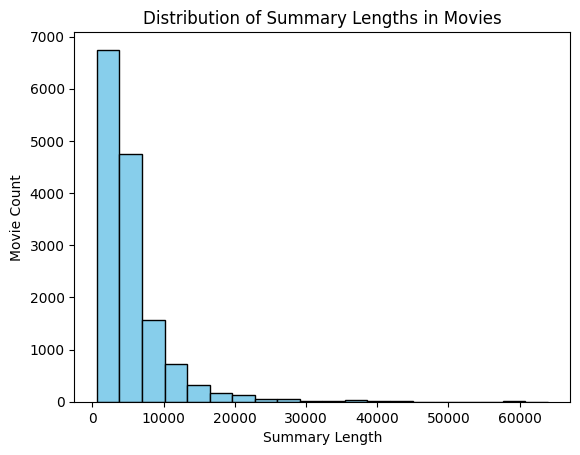

In [49]:
# Plot the histogram
plt.hist(summary_lengths, bins=20, color='skyblue', edgecolor='black')
plt.ylabel('Movie Count')  # y-axis will be the count of movies
plt.xlabel('Summary Length')  # x-axis will be the length of the summaries
plt.title('Distribution of Summary Lengths in Movies')
plt.show()

### Movies' genres exploration

Number of unique genres: 333


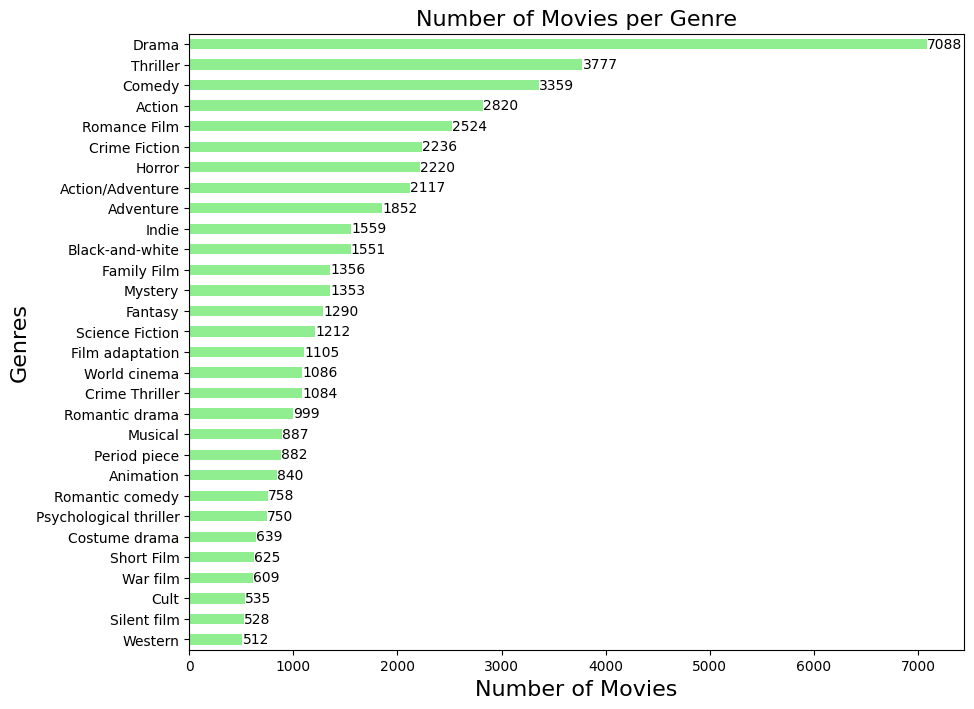

In [24]:
all_genres = LDA_df['Movie genres'].explode() # Changes elements from a list to a row

num_unique_genre = all_genres.nunique() # Creates list which each type of genre in all_genres
print("Number of unique genres:", num_unique_genre)

# Plot the number of movies per top 30 genres

genres_counts = all_genres.value_counts()

plt.figure(figsize=(10, 8))
bars = genres_counts.head(30).sort_values(ascending=True).plot(kind='barh', color='lightgreen') # kind='barh' allows us to flip the axis
for index, value in enumerate(genres_counts.head(30).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')
plt.xlabel('Number of Movies', fontsize=16)
plt.ylabel('Genres', fontsize=16)
plt.title('Number of Movies per Genre', fontsize=16)
plt.show()

*Comment: Drama is the clear leader when it comes to movie genres, followed by Comedy and Romance. This makes sense since these genres appeal to a wide range of audiences. Genres like Thriller, Action, and Documentary are also popular, showing that people enjoy excitement and real-life stories. On the other end, niche genres like 'Cult' and 'Political drama' are much less common, which isn't surprising given their more specific audience.*

*Here we decided to show only the top 30 genres to keep the chart clear and easy to read.*

# AJOUTER WORDCLOUD POUR 1 GENRE => 1 Word cloud le faire interactif
# PEUT FAIRE LA MEME POUR LE MPST labels

### Movies Box office exploration

In [26]:
features_df['IMDB Box-office'] = pd.to_numeric(features_df['IMDB Box-office'], errors='coerce')

# Remove the NaNs to plot
box_office_without_nan = features_df['IMDB Box-office'].dropna()

<ipython-input-26-ce0e867b66be>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



For plotting, we select a threshold (4e8) for better visualization as there are some outliers (very large values) that will collapse the plot on the left and make it unreadable.

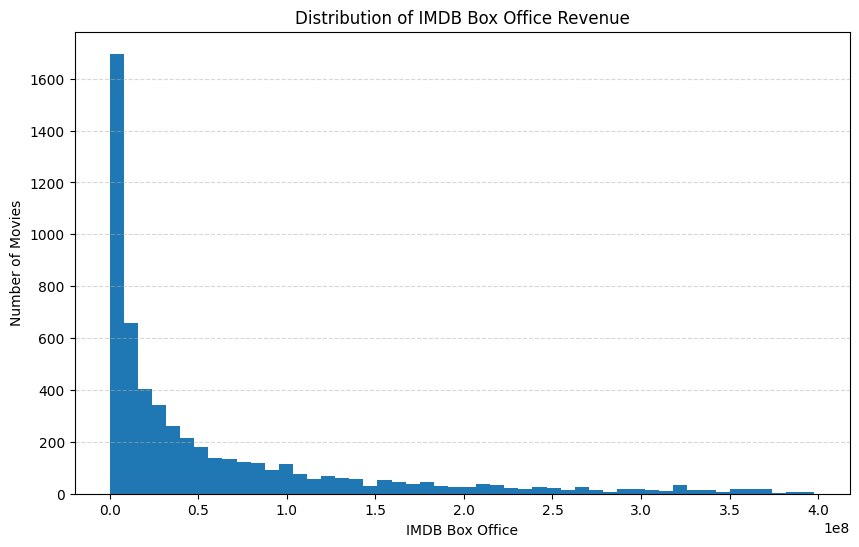

In [27]:
threshold = 4e8
box_office_filtered = features_df['IMDB Box-office'][features_df['IMDB Box-office'] < threshold]

# Plot the histogram
box_office_filtered.plot(kind='hist', figsize=(10, 6), bins=50)
plt.xlabel('IMDB Box Office')
plt.ylabel('Number of Movies')
plt.title('Distribution of IMDB Box Office Revenue')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

We observe that most movies results in a small box-office.

### Movies Ratings exploration

count    5904.000000
mean        6.518513
std         1.009365
min         1.300000
25%         6.000000
50%         6.600000
75%         7.200000
max         9.300000
Name: averageRating, dtype: float64

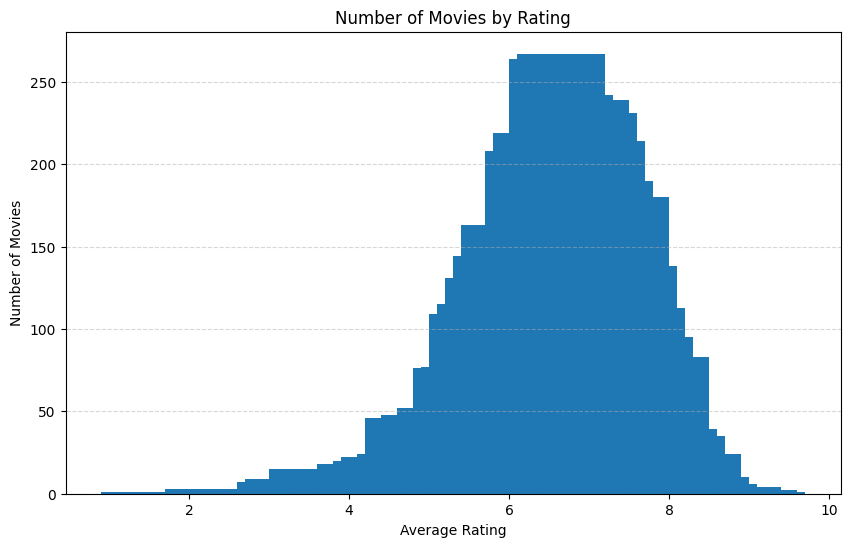

In [32]:
# Box office statistics
display(features_df['averageRating'].describe())

# Plot average rating per year
rating_counts = features_df['averageRating'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Average Rating')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Rating')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

It seems that raters tend to find movies rather good on average. Extreme ratings are very rare (<1 and >9).

### Movies countries exploration

Number of unique countries: 88


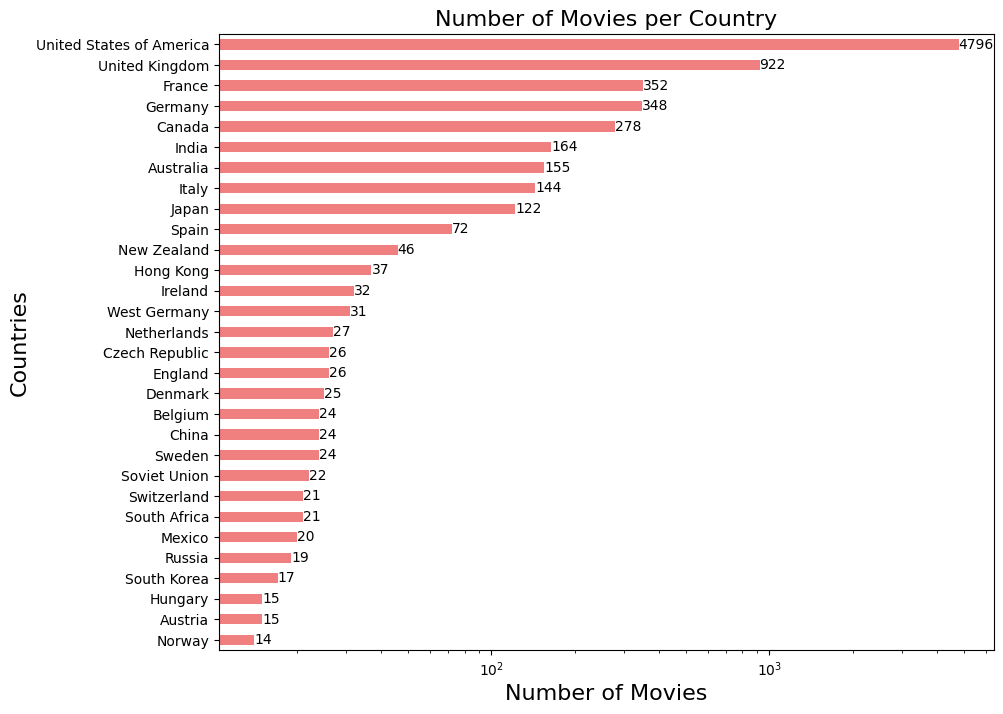

In [33]:
# Number of movies per country
all_countries = features_df['Movie countries'].explode()
countries_counts = all_countries.value_counts()

# Number of countries
num_unique_countries = all_countries.nunique()
print("Number of unique countries:", num_unique_countries)

# Plot the top 30 countries with most amount of movies
plt.figure(figsize=(10, 8))
bars = countries_counts.head(30).sort_values(ascending=True).plot(kind='barh', color='lightcoral')

for index, value in enumerate(countries_counts.head(30).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')

plt.xlabel('Number of Movies', fontsize=16)
plt.ylabel('Countries', fontsize=16)
plt.title('Number of Movies per Country', fontsize=16)
plt.xscale('log') # Easier to visualise with log scale
plt.show()


The United States has the most movies by far, showing its huge impact on the film industry. The United Kingdoms and France come next, followed by Germany, India and Canada who also produce numerous movies.

We decided to show only the top 30 countries to keep the chart clear and easy to read.

For better readibility we used a log scale on the x axis.

### Movies languages exploration

The dataset contains 124  languages.


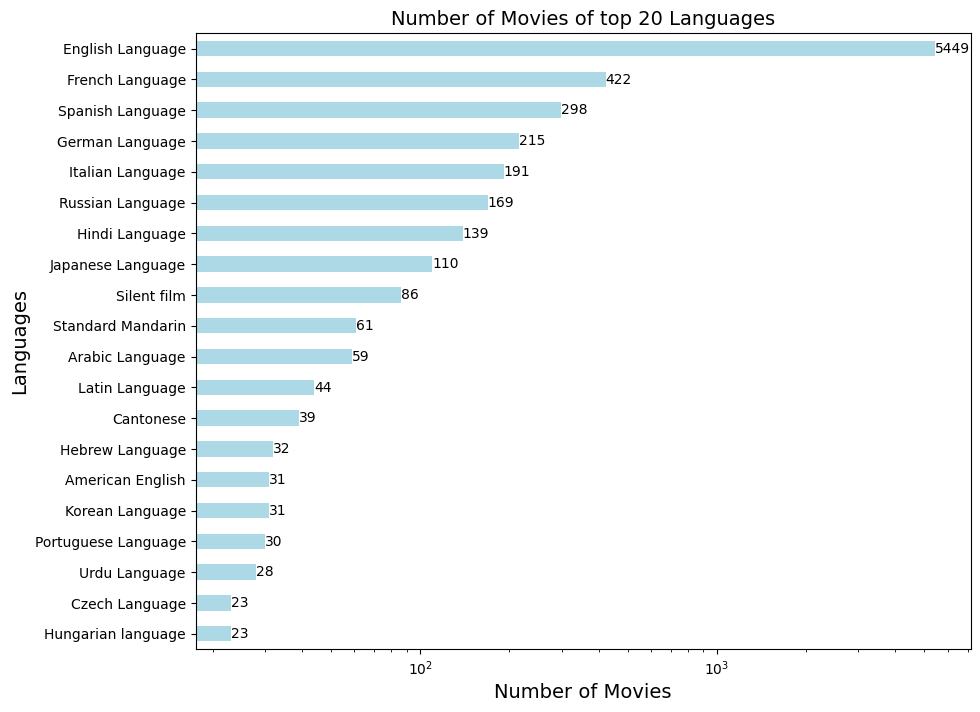

In [34]:
# Number of movies with a certain language available
all_languages = features_df['Movie languages'].explode()
language_counts = all_languages.value_counts()

# Number of language available
num_unique_languages = all_languages.nunique()
print("The dataset contains", num_unique_languages, " languages.")

# Plot the number of movies per language
plt.figure(figsize=(10, 8))
bars = language_counts.head(20).sort_values(ascending=True).plot(kind='barh', color='lightblue')

for index, value in enumerate(language_counts.head(20).sort_values(ascending=True)):
    plt.text(value, index, str(value), va='center')

plt.xlabel('Number of Movies',fontsize=14)
plt.ylabel('Languages',fontsize=14)
plt.title('Number of Movies of top 20 Languages', fontsize=14)
plt.xscale('log')
plt.show()

As previously seen, English is largely dominant. This can be attributed to its role as a global lingua franca, making films more accessible to international audiences. Additionally, major movie industries in countries like the US and other English-speaking regions contribute to the high number of English-language films.

For better visibility, we chose to display only the top 20 languages in this chart. It is also noticeable that the number of movies per language drops off quickly after the most common languages, highlighting the dominance of a few major languages in movie production and a long tail of less commonly represented languages. For better readibility we used a log scale on the x axis.

### Movies release year exploration

Here we do a general analysis about the total number of movies released each year.

count    5904.0
mean     1987.0
std        23.0
min      1908.0
25%      1976.0
50%      1995.0
75%      2005.0
max      2013.0
Name: Movie release date, dtype: float64

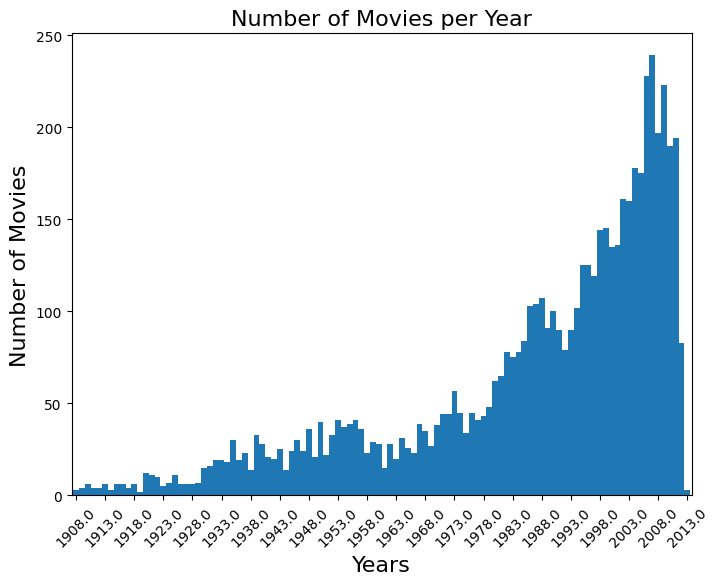

In [35]:
all_years = features_df['Movie release date'].explode()
years_counts = all_years.value_counts()
display(all_years.describe().round(0))

# Number of movies per year

plt.figure(figsize=(8, 6))
plot_years_counts = all_years.value_counts().sort_index().plot(kind='bar', width=1)

plt.xlabel('Years', fontsize=16 )
plt.ylabel('Number of Movies', fontsize=16)
plt.title('Number of Movies per Year', fontsize=16)

plt.xticks(range(0, len(all_years.value_counts().sort_index()), 5),
           all_years.value_counts().sort_index().index[::5],
           rotation=45)

plt.show()

The movie production has grown steadily over time, with a big jump starting in the 1990s and peaking in the early 2000s. The increase after the 1980s is likely due to better technology and more people making movies around the world. The early years have fewer movies because the film industry was just getting started. Data starting from 2012 is incomplete (e.g. the dataset contains only one movie in 2016).

The U.S. consistently dominates movie production across all decades, though its share decreases over time from near-total dominance in the early 20th century to around 40-50% in the later decades. Other countries, such as India, the UK, and France, start contributing more significantly from the 1950s onward, indicating a diversification in global movie production over the decades.

# Part 2: Latent Dirichlet Allocation (LDA)
LDA offers a way to cluster together movies that reflect similar themes, based on textual descriptions. The model does unsupervised learning, as the themes fo the movies are not known. Our problem was that the movie summaries only give too few informations to use LDA. That's why we extracted the synopsis of the movies through another dataset called "Movie Plot Synopses with Tags" (MPST). Those synopsis are around 10 times longer than the summaries, giving way more informations to the LDA model.

## 2.1 Preprocessing

To preprocess the synopses, we use the `spacy` analyzer for English language. We apply the following pipeline to the synopses :

### Preprocess pipeline
1.   Tokenization
2.   Stop words, punctuation and numbers removal (except dates)
3.   Lemmatization
4.   Remove character names
5. Add bigrams


Removing stop words and character names before using LDA is important as those very frequent words are useless when defining global themes. Bigrams are sequences of two words that could capture additionnal informations.

_Load the dataframe that we produced earlier_

In [4]:
movie_final = pd.read_csv('Data/LDA_movie.csv') #Import our dataframe

synopses = movie_final['plot_synopsis'].tolist() #Convert synopses column to a list
movie_ids = movie_final['imdb_id'].tolist() #Convert IMDB_ID column to a list 
print(f'Number of synopses : {len(synopses)}')

Number of synopses : 14604


_Load the spacy analyzer in English_

In [ ]:
Thomas = True #A enlever tout a la fin mais sinon ca marche pas pour moi snif
if Thomas:
    nlp = spacy.load('/opt/anaconda3/lib/python3.12/site-packages/en_core_web_sm/en_core_web_sm-3.7.1')
else:
    nlp = spacy.load("en_core_web_sm")
nlp.remove_pipe("parser") #We don't need the parser (win comp. time)

_Preprocess synopses_

**Note:** The following cell performs preprocessing on movie synopses. It takes a while to run, since it processes a large dataset. To skip this cell you can use the resulting file saved in `Data/processed_data.txt` instead by setting `run_processing` to `False`.


In [8]:
from gensim.models.phrases import Phrases

run_processing = False
path_file = 'Data/processed_data.txt'

if run_processing:
    docs = list()
    for doc in nlp.pipe(synopses, n_process=5, batch_size=10):

        ents = doc.ents  # Get entities

        # Lemmatize tokens (running --> run) after removing numbers, punctuation, stopwords and entities.
        doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and len(token) > 2 and token.ent_type_ == ""]

        # Add entities, but only if they are not character names and longer than 1 word (as it's usually character names not recognized as PERSON).
        doc.extend([str(entity) for entity in ents if len(entity) > 1 and entity.label_ != "PERSON"])
        docs.append(doc)

    # Add bigrams to docs (only ones that appear 15 times or more).
    bigram = Phrases(docs, min_count=15)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token: # Token is a bigram, add to document.
                docs[idx].append(token)
else:
    with open(path_file, "rb") as file:
        docs = pickle.load(file)

In [ ]:
#TO REMOVE AT THE END
'''# Create the processed file
path_file = '/content/drive/My Drive/P3/processed_data.txt'
# Save processed synopses to a file
with open(path_file, "wb") as file:
    pickle.dump(docs, file)'''

Let's see the result of our preprocessing :

In [12]:
print(f'Original : {synopses[0]}')
print(f'Preprocessed : {docs[0]}')

Original : Two thousand years ago, Nhagruul the Foul, a sorcerer who reveled in corrupting the innocent and the spread of despair, neared the end of his mortal days and was dismayed. Consumed by hatred for the living, Nhagruul sold his soul to the demon Lords of the abyss so that his malign spirit would survive. In an excruciating ritual, Nhagrulls skin was flayed into pages, his bones hammered into a cover, and his diseased blood became the ink to pen a book most vile. Creatures vile and depraved rose from every pit and unclean barrow to partake in the fever of destruction. The kingdoms of Karkoth were consumed by this plague of evil until an order of holy warriors arose from the ashes. The Knights of the New Sun swore an oath to resurrect hope in the land. The purity of their hearts was so great that Pelor, the God of Light, gave the Knights powerful amulets with which to channel his power. Transcendent with divine might, the Knights of the New Sun pierced the shadow that had darkene

To prepare the data for LDA, we first create a dictionnary of all the words except ones that are too rare or too common. Then we create the bag-of-words representation of the documents.

In [13]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)

# Remove too rare and too common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))

Number of unique tokens: 32119


## Number of topics selection

The main parameter to give when it comes to LDA is the number of topics LDA will produce. To select the number of topics we need a coherence score, quantifying how good are the topics formed by the LDA model. Gensim provides a function to get a coherence score called $C_v$ but after checking some documentation [check here](https://www.baeldung.com/cs/topic-modeling-coherence-score), we came to the conclusion that Gensim function wasn't really reliable. So we build our own coherence score using the Word2Vec model. Word2Vec is a NLP technique which consists in representing words with vectors that capture the meaning of the word. This means two words with similar meaning (i.e. prince and king) will be close in the vector space. For each LDA model, we can attribute a coherence score based on the similarity between topics with the following formula :

$C_{sim} = \frac{1}{N-1}\sum_{i ≠ j}\frac{\frac{\text{intra(i)} + \text{intra(j)}}{2}}{\text{inter(i,j)}}$

with $N$ the number of topics, $\text{intra(i)}$ the average similarity between words of topic $i$ and $\text{inter(i, j)}$ the average similarity between words of topic $i$ and $j$.

The working principle is quite intuitive:
* Maximize intra-topic similarity: similarity of words in the same topic.

* Minimize Inter-topic similarity: the similarity of words across different topics.

The function to get the similarity coherence score $C_{sim}$ is available in the `utils/helpers.py` file.

### Run LDA for various number of topics

**Note:** Again this cell takes very long to run. Set `run_lda` to `False` to skip it and load the resulting files.


In [24]:
run_lda = False
if run_lda:
    from gensim.models import LdaMulticore
    from gensim.models import CoherenceModel
    from gensim.models import KeyedVectors

    model_w2v = KeyedVectors.load("src/models/word2vec.model") #Get Word2Vec model
    seed = 42
    params = {'passes': 10, 'random_state': seed}
    coherence_c_v = []
    coherence_sim = []
    models = []
    topic_number = range(4, 19, 1)

    for topic in topic_number:
        model = LdaMulticore(corpus=corpus, num_topics=topic, id2word=dictionary, workers=6,
                        passes=params['passes'], random_state=params['random_state'])
        models.append(model)
        cohe = CoherenceModel(model=model, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_c_v.append(cohe.get_coherence())
        coherence_sim.append(get_similarity(model, model_w2v))
else:
    with open('Data/coherence_c_v.pkl', "rb") as file:
        coherence_c_v = pickle.load(file)
    with open('Data/coherence_sim.pkl', "rb") as file:
        coherence_sim = pickle.load(file)
    with open('src/models/lda_models_4_to_15.pkl', "rb") as file:
        models = pickle.load(file)

Let's see what number of topics has the best coherence.

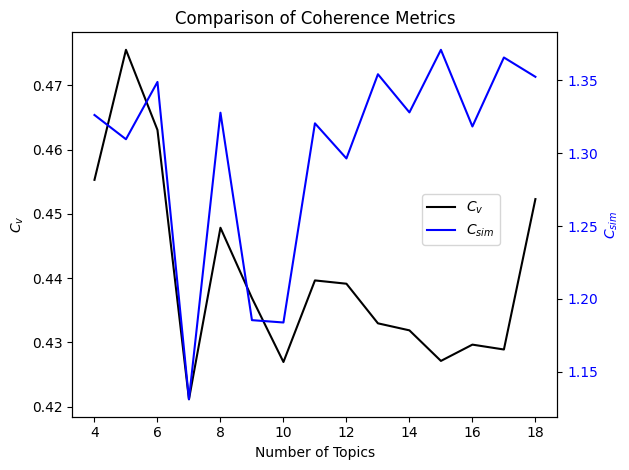

In [23]:
# Create a figure and primary axis
fig, ax1 = plt.subplots()
topic_number = range(4, 19, 1)

ax1.plot(topic_number, coherence_c_v, 'k', label=r'$C_v$')
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel(r'$C_v$', color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax2 = ax1.twinx()
ax2.plot(topic_number, coherence_sim, 'b', label=r'$C_{sim}$')
ax2.set_ylabel(r'$C_{sim}$', color='b')
ax2.tick_params(axis='y', labelcolor='b')
fig.legend(loc="upper right", bbox_to_anchor=(0.80, 0.6))
plt.title('Comparison of Coherence Metrics')
fig.tight_layout()
plt.show()

We observe that both metrics don't give similar results for all the different number of topics. We decide to prioritize the similarity coherence score $C_{sim}$ as $C_v$ isn't reliable. To maximize coherence we choose the number of topics to be **15**. We will use this model for the rest of the project.

In [25]:
lda_model = models[11]

Let's see what's the word distribution for each topic :

In [28]:
for topic_id, topic_words in lda_model.print_topics(num_words=7):
    print(f"Topic {topic_id}: {topic_words}")

Topic 0: 0.014*"car" + 0.009*"get" + 0.007*"gun" + 0.007*"shoot" + 0.006*"police" + 0.006*"drive" + 0.006*"say"
Topic 1: 0.007*"shoot" + 0.005*"order" + 0.005*"officer" + 0.004*"escape" + 0.004*"police" + 0.004*"fire" + 0.004*"soldier"
Topic 2: 0.006*"film" + 0.006*"get" + 0.005*"home" + 0.005*"love" + 0.005*"play" + 0.005*"friend" + 0.005*"father"
Topic 3: 0.006*"garden" + 0.005*"uncle" + 0.005*"grow" + 0.005*"sister" + 0.004*"house" + 0.004*"soon" + 0.004*"die"
Topic 4: 0.005*"head" + 0.005*"room" + 0.004*"get" + 0.004*"run" + 0.004*"look" + 0.004*"say" + 0.004*"know"
Topic 5: 0.006*"fight" + 0.005*"father" + 0.004*"Carrie" + 0.004*"death" + 0.004*"capture" + 0.004*"dragon" + 0.003*"force"
Topic 6: 0.008*"Macbeth" + 0.006*"whale" + 0.005*"Emily" + 0.005*"king" + 0.005*"witch" + 0.005*"castle" + 0.005*"prophecy"
Topic 7: 0.008*"Monty" + 0.005*"barricade" + 0.005*"money" + 0.005*"house" + 0.005*"Marius" + 0.004*"life" + 0.004*"escape"
Topic 8: 0.007*"ship" + 0.006*"attack" + 0.005*"esc

From this list of words, we can easily dicerner some topics. For example the topic 0 seems to contain action/gangster movies, with keywords like police, car, gun and shoot. We asked the NLP AI Chat-GPT ([source](https://chatgpt.com)) to give a name to each topic depending on its words distribution. Here are the names of each topic :

| Topic | Keywords                                    | Theme                       |
|-------|---------------------------------------------|-----------------------------|
| 0     | Car, Gun, Police, Gang                     | Crime and Action            |
| 1     | Shoot, Soldier, Fire, Attack               | Military and Tactical Ops   |
| 2     | Home, Love, Friend, Mother, Father         | Family Drama and Relationships |
| 3     | Garden, Vampire, Shrink, Lord              | Mystical and Supernatural   |
| 4     | Room, Escape, Head, Run, Look              | Suspense and Chase          |
| 5     | Fight, Dragon, Army, King                  | Medieval and Fantasy Battles|
| 6     | Macbeth, Witch, Prophecy, Castle           | Shakespearean and Historical Drama |
| 7     | Barricade, Money, House, Escape            | Rebellion and Urban Struggle |
| 8     | Ship, Zombie, Rescue, Attack               | Survival and Sci-Fi Adventure |
| 9     | Say, Ask, Look, Room                       | Dialogue and Interpersonal Interaction |
| 10    | Family, Love, Death, Child, Father         | Family and Tragedy          |
| 11    | Musketeer, Duel, Guard, Fight              | Heroic Tales and Duels      |
| 12    | Murder, Police, Body, Killer, Dead         | Murder Mystery and Investigation |
| 13    | Home, Town, Family, Mother, Father         | Small Town and Familial Stories |
| 14    | Know, Want, Life, Decide                   | Philosophical and Character Reflections |

Let's add to the dataframe the distribution of themes for each movie, and the main theme (the one with highest distribution). 

In [32]:
len(topic_distrib)

14252

In [30]:
topic_distrib = [sorted(lda_model.get_document_topics(doc), key=lambda x: x[1], reverse=True) for doc in corpus]
movie_final.insert(loc=len(movie_final.columns), column='Topics', value=topic_distrib)
topic_dic= {1 : 'Crime and Action', 2 : 'Military', 3 : 'Relationships', 4 : 'Supernatural', 5 : 'Suspense', 6 : 'Medieval', 7 : 'Shakespearean', 8 : 'Rebellion and Struggle', 9 : 'Sci-Fi', 10 : 'Dialogue', 11 : 'Family and Tragedy', 12 : 'Heroic Tales', 13 : 'Murder Mystery', 14 : 'Familial Stories', 15 : 'Philosophical'}
movie_final['Main Topic'] = movie_final['Topics'].apply(lambda x : topic_dic[x[0][0] + 1])
movie_final.head()

ValueError: Length of values (14252) does not match length of index (14604)

In [ ]:
for topic_id, topic_words in model.print_topics(num_words=10):
    print(f"Topic {topic_id}: {topic_words}")
print(f"Coherence = {coherence_model.get_coherence()}")

In [ ]:
topics = range(5, 22, 2)
plt.plot(topics, coherence_scores, c='b')
plt.plot(topics2, coherence_scores_1to4, c='b')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')

In [ ]:
import pyLDAvis.gensim_models
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

**Note:** The following cell builds a dictionary from the processed sentences, converts those sentences into a bag-of-words representation, and then trains an LDA model to extract 10 topics from the text data. It takes a while to run, since it processes a large dataset. To skip this cell you can use the precomputed model saved in `Data/lda_model.model` instead by setting `run_processing` to `False`.